# Transfer Learning using ResNet34

In [4]:
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

## Loading Data

In [5]:
transforms = transforms.Compose([
transforms.Resize(256),
transforms.CenterCrop(224),
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406],
[0.229, 0.224, 0.225])
])
train_set = datasets.ImageFolder("data_transfer_learning/train",transforms)
val_set = datasets.ImageFolder("data_transfer_learning/val",transforms)
model = models.resnet34(pretrained=True)

In [6]:
# Define Hyperparameters

data_dir = "./data_transfer_learning"
num_classes = 2
batch_size = 8
num_epochs = 20

# Set to false as we want to fine tune the whole model and not just the last layer
feature_extract = False

In [115]:
# To keep track of loss and accuracy to plot later
train_loss =[]
train_acc = []
val_loss = []
val_acc = []

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Train and Validate at every epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set to training mode
                model.train()  
            else:
                # Set to validation mode
                model.eval()   

            # Initialize 
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)


                    # backward and optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Computing the loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # Store loss and accuracy at each epoch
            if phase == 'train':
              train_loss.append(epoch_loss)
              train_acc.append(epoch_acc)
            else:
              val_loss.append(epoch_loss)
              val_acc.append(epoch_acc)

            # deep copy to store the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

## Modifying the final layer for two classes

In [108]:
def initialize_model(num_classes):

    input_size = 0
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 224
    
    return model, input_size

In [109]:
# Initialize the model for this run
model, input_size = initialize_model(num_classes)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

## Creating dataset dictionary

In [110]:
print("Initializing Datasets and Dataloaders...")

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transforms) for x in ['train', 'val']}

dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [111]:
dataloaders_dict

{'train': <torch.utils.data.dataloader.DataLoader at 0x1c958a2eb38>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x1c958a3dc50>}

In [112]:
dataloaders_dict['train']

In [113]:
len(dataloaders_dict['train'].dataset)

60

## Training the model

In [100]:
model = model.to(device)

# Observe that all parameters are being optimized
params_to_update = model.parameters()
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9,weight_decay=0.1)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model, hist = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs)

Epoch 0/19
----------
train Loss: 0.6735 Acc: 0.5667
val Loss: 0.2139 Acc: 1.0000

Epoch 1/19
----------
train Loss: 0.1217 Acc: 1.0000
val Loss: 0.0414 Acc: 1.0000

Epoch 2/19
----------
train Loss: 0.1273 Acc: 0.9833
val Loss: 0.0184 Acc: 1.0000

Epoch 3/19
----------
train Loss: 0.3311 Acc: 0.7833
val Loss: 0.0188 Acc: 1.0000

Epoch 4/19
----------
train Loss: 0.0460 Acc: 1.0000
val Loss: 0.0545 Acc: 1.0000

Epoch 5/19
----------
train Loss: 0.1249 Acc: 0.9500
val Loss: 0.0086 Acc: 1.0000

Epoch 6/19
----------
train Loss: 0.0146 Acc: 1.0000
val Loss: 0.0265 Acc: 1.0000

Epoch 7/19
----------
train Loss: 0.0223 Acc: 1.0000
val Loss: 0.0164 Acc: 1.0000

Epoch 8/19
----------
train Loss: 0.0168 Acc: 1.0000
val Loss: 0.0145 Acc: 1.0000

Epoch 9/19
----------
train Loss: 0.0076 Acc: 1.0000
val Loss: 0.0109 Acc: 1.0000

Epoch 10/19
----------
train Loss: 0.1095 Acc: 0.9667
val Loss: 0.0047 Acc: 1.0000

Epoch 11/19
----------
train Loss: 0.0409 Acc: 0.9833
val Loss: 0.0303 Acc: 1.0000

Ep

## Train and validation loss curves

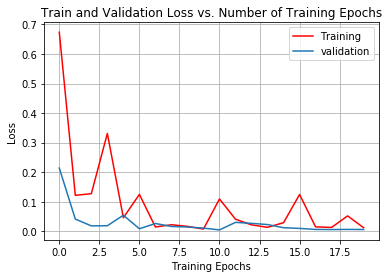

In [101]:
plt.title("Train and Validation Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")

plt.plot(np.arange(num_epochs),train_loss,'r',label="Training")
plt.plot(np.arange(num_epochs),val_loss,label="validation")
plt.legend()
plt.grid(True)
plt.show()

## Final Accuracies

<table style="width:50%">
  <tr>
    <th>Training</th>
    <th>Validation</th>
  </tr>
  <tr>
    <td>100%</td>
    <td>100%</td>
  </tr>

</table>